In [1]:
import pandas as pd

pred = pd.read_pickle("D:/Desktop/high_freq/pred.pkl")
pred

predict       price     volume         R
time                code                                               
2023-03-13 09:31:00 sh600010  0.000125   16.664593  7126200.0  0.005076
                    sh600015  0.000056   27.027622  1450667.0  0.000000
                    sh600016  0.000026  106.834854  4543480.0  0.000000
                    sh600018  0.000014    8.241614   470220.0  0.001866
                    sh600019 -0.000318   19.958448  1673668.0  0.004587
...                                ...         ...        ...       ...
2023-04-13 14:57:00 sz002460 -0.000014  876.770935    69261.0  0.000307
                    sz300122 -0.000024  353.269989    44437.0  0.000000
                    sz300274 -0.000002  679.735840    78325.0 -0.000200
                    sz300496 -0.000010  406.489899    73100.0 -0.000098
                    sz300661  0.000117  964.168701    65139.0  0.001018

[1640566 rows x 4 columns]

In [2]:
from scutquant import executor, report

不考虑手续费的曲线相当美好, 加上手续费就是另一个故事了...

In [3]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "sigma": 1,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": "share", 
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票成交量的10%(例如T+1时下单，下单手数不会超过T时成交量的5%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0,
        "cost_sell": 0,  
        "min_cost": 0,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 3.642337996946636
Annualized Volatility: 0.15844930018836056
Annualized Return(Benchmark): 0.4236395589136228
Annualized Volatility(Benchmark): 0.05285152712374649 

Cumulative Rate of Return: 0.1580133768008709
Cumulative Rate of Return(Benchmark): 0.03432960930031137
Cumulative Excess Rate of Return: 0.12368376750055954 

Max Drawdown: -0.013147295720498553
Max Drawdown(Benchmark): -0.018857369418701864
Max Drawdown(Excess Return): -0.007173824632386694 

Sharpe Ratio: 1.3081640813125017
Sortino Ratio: 26.522239735652335
Information Ratio: 0.9434147882564949 

Beta: 2.8652319897424476
Alpha: 0.012885609421168162
Epsilon: 0.014415341834968953
Profitable Days(%): 0.999451854558743


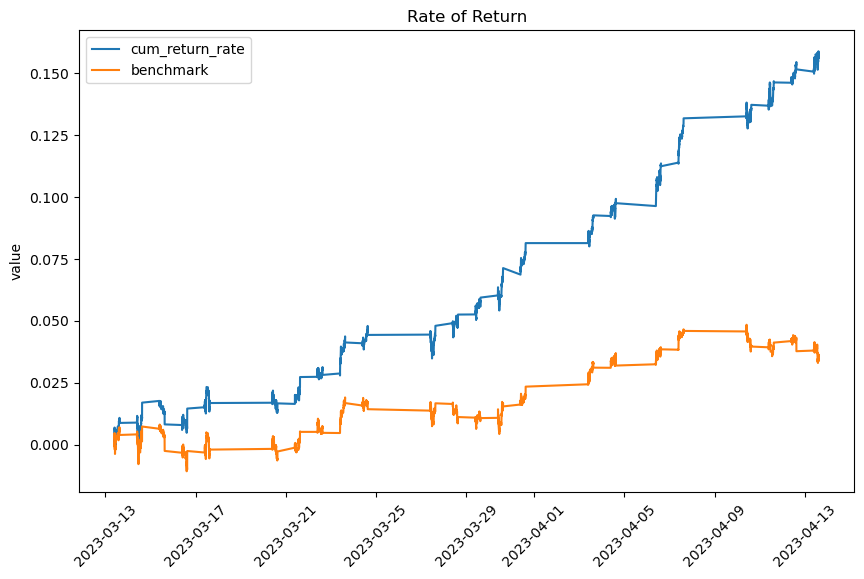

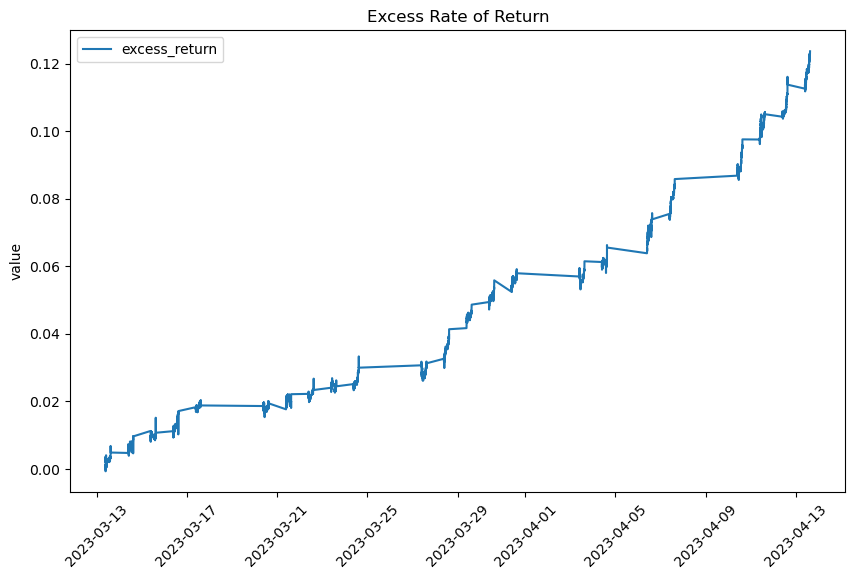

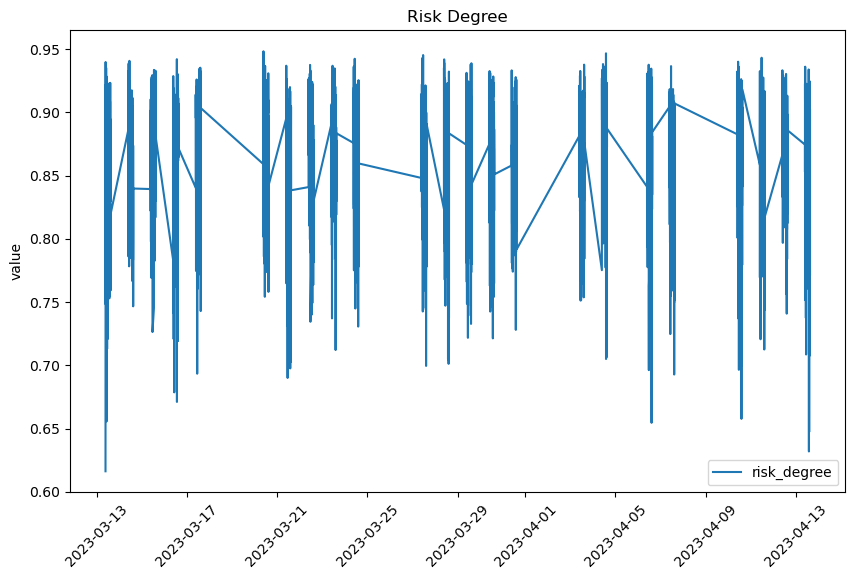

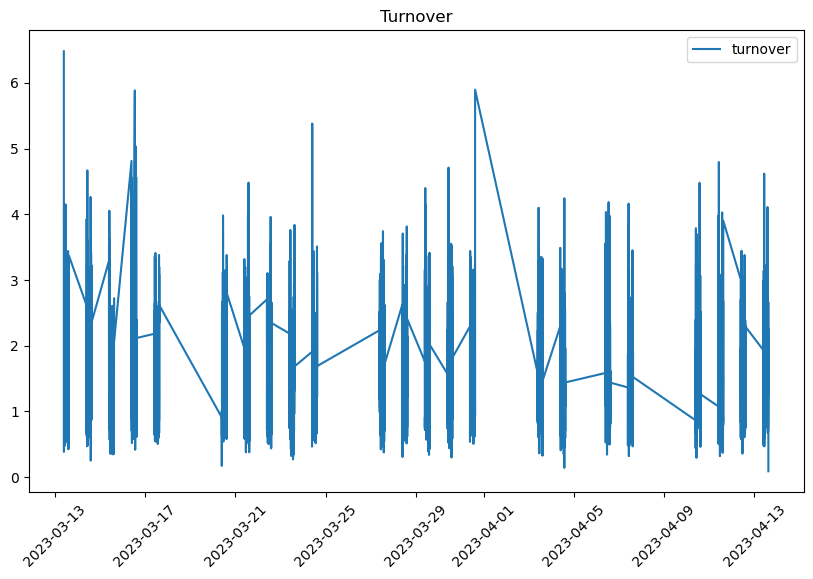

In [4]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, rf=0, freq=0.0044, time=exe.time)